# Initialzing Modules

In [2]:
import logging
import os 
import sys
import pickle

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score

import gensim.downloader as api

from kneed import KneeLocator

import optuna

In [4]:
# Set logging levels with timestamp
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [5]:
# # Load a pre-trained Word2Vec model
# wv = api.load('word2vec-google-news-300') # TODO: If I use this load this into storage for easier download.

In [6]:
wv = pickle.load(open('wordvec-google-news-300.pkl', 'rb'))

# Data Preparation

## Loading In Data 

In [7]:
df = pd.read_csv('clickbait_data.csv')

In [8]:
def text_to_vector(text):
    # Tokenize the text into words
    words = text.split()
    
    # Initialize an empty list to store vectors
    word_vectors = []
    
    for word in words:
        if word in wv.key_to_index:
            # Add the word's vector to the list
            word_vectors.append(wv[word])
    
    # If we have at least one word vector, return the mean vector
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        # Return a zero vector if none of the words were in the model's vocabulary
        return np.zeros(300)

# Apply the function to each item in the DataFrame column
df['vector'] = df['headline'].apply(text_to_vector)

## PCA - Compression

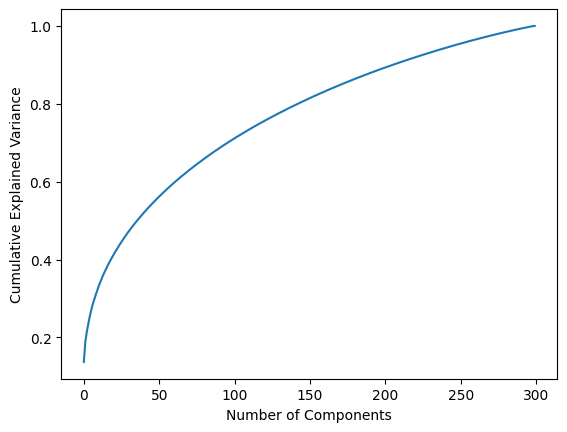

In [9]:
vectors = np.stack(df['vector'].values)
pca = PCA().fit(vectors)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()



In [10]:
n_components = range(1, 301)
knee_locator = KneeLocator(n_components, cumulative_variance, curve='convex', direction='increasing')
best_n_components = knee_locator.knee
print("Best N Components", best_n_components)

Best N Components 300


In [11]:
# Apply PCA with the optimized number of components
pca_optimized = PCA(n_components=best_n_components)
vectors = list(pca_optimized.fit_transform(np.stack(df['vector'].values)))

# Adding Compressed Data to the Dataframe
for i in range(best_n_components):
    df["vector"+str(i)] = [v[i] for v in vectors]

/tmp/ipykernel_92100/3823163554.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["vector"+str(i)] = [v[i] for v in vectors]
/tmp/ipykernel_92100/3823163554.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["vector"+str(i)] = [v[i] for v in vectors]
/tmp/ipykernel_92100/3823163554.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmen

In [12]:
X = df.drop(columns=['headline', 'clickbait', 'vector'])
y = df['clickbait']

In [13]:
# Set up train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing Models

In [14]:
logistic_regression = LogisticRegression()
support_vector_machine = SVC()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()

## Optuna Objective Functions

In [15]:
def objective_lr(trial):
    logging.info(f'Running trial {trial.number}')
    param = {
        'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
    }
    classifier_obj = LogisticRegression(**param)
    
    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict(X_test)

    logging.info(f'Accuracy: {accuracy_score(y_test, y_pred)}')

    return accuracy_score(y_test, y_pred)

def objective_gbc(trial):
    logging.info(f'Running trial {trial.number}')
    # Define the hyperparameters to tune
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 60),
        'max_features': trial.suggest_int('max_features', 1, 60),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }
    
    # Initialize and train the Gradient Boosting Classifier
    classifier_obj = GradientBoostingClassifier(**param)
    classifier_obj.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = classifier_obj.predict(X_test)

    logging.info(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    
    # Return the accuracy score
    return accuracy_score(y_test, y_pred)


# Objective function for SVM
def objective_svm(trial):
    logging.info(f'Running trial {trial.number}')
    param = {
        'C': trial.suggest_float('c', 1e-10, 1e10, log=True),
        'gamma': trial.suggest_float('gamma', 1e-10, 1e10, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    }
    classifier_obj = SVC(**param)
    
    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict(X_test)
    logging.info(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    return accuracy_score(y_test, y_pred)

# Objective function for Decision Tree
def objective_dt(trial):
    logging.info(f'Running trial {trial.number}')
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
    }
    classifier_obj = DecisionTreeClassifier(**param)
    
    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict(X_test)

    logging.info(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    return accuracy_score(y_test, y_pred)

# Objective function for Random Forest
def objective_rf(trial):
    logging.info(f'Running trial {trial.number}')
    param = {
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
    }
    classifier_obj = RandomForestClassifier(**param)
    
    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict(X_test)

    logging.info(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    
    return accuracy_score(y_test, y_pred)

# Training

In [16]:
n_trials = 100

## Gradient Boosted Classifier

In [17]:
# Commenting Out to long run times.
# study_gbc = optuna.create_study(direction='maximize')
# study_gbc.optimize(objective_gbc, n_trials=n_trials)

# print(study_gbc.best_params)

## Logistic Regression

In [18]:
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=n_trials)

print(study_lr.best_params)

[I 2024-03-13 18:25:24,908] A new study created in memory with name: no-name-99620d08-520c-4ed2-9eb3-a12833a3c8ec
2024-03-13 18:25:24,909 - root - INFO - Running trial 0
2024-03-13 18:25:25,664 - root - INFO - Accuracy: 0.97984375
[I 2024-03-13 18:25:25,667] Trial 0 finished with value: 0.97984375 and parameters: {'C': 33.53110502784653}. Best is trial 0 with value: 0.97984375.
2024-03-13 18:25:25,670 - root - INFO - Running trial 1
2024-03-13 18:25:25,840 - root - INFO - Accuracy: 0.94640625
[I 2024-03-13 18:25:25,842] Trial 1 finished with value: 0.94640625 and parameters: {'C': 0.0005081754381231118}. Best is trial 0 with value: 0.97984375.
2024-03-13 18:25:25,843 - root - INFO - Running trial 2
2024-03-13 18:25:26,779 - root - INFO - Accuracy: 0.97953125
[I 2024-03-13 18:25:26,782] Trial 2 finished with value: 0.97953125 and parameters: {'C': 126.16700359839054}. Best is trial 0 with value: 0.97984375.
2024-03-13 18:25:26,784 - root - INFO - Running trial 3
2024-03-13 18:25:27,587 

KeyboardInterrupt: 

In [ ]:
lr = LogisticRegression(**study_lr.best_params)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(study_lr.best_params)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

{'C': 1.562868220273054}
Accuracy: 0.981875


In [ ]:
# Save Model 
pickle.dump(lr, open('logistic_regression.pkl', 'wb'))

In [ ]:
lr_v = pickle.load(open('logistic_regression.pkl', 'rb'))

In [ ]:
lr_v.predict(X_test)

array([0, 0, 1, ..., 1, 1, 0])

## Support Vector Machines 

In [ ]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=n_trials)

print(study_lr.best_params)

[I 2024-03-13 18:16:49,926] A new study created in memory with name: no-name-15b7373a-58cc-426a-b866-ccd70e58b246
2024-03-13 18:16:49,933 - root - INFO - Running trial 0


## Decision Trees

In [19]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt, n_trials=n_trials)

[I 2024-03-13 18:26:13,965] A new study created in memory with name: no-name-d370cd41-f22f-4480-9bdf-4f9d443f49e8
2024-03-13 18:26:13,967 - root - INFO - Running trial 0
2024-03-13 18:26:22,721 - root - INFO - Accuracy: 0.95265625
[I 2024-03-13 18:26:22,723] Trial 0 finished with value: 0.95265625 and parameters: {'max_depth': 17, 'min_samples_split': 77, 'min_samples_leaf': 21}. Best is trial 0 with value: 0.95265625.
2024-03-13 18:26:22,724 - root - INFO - Running trial 1
2024-03-13 18:26:34,262 - root - INFO - Accuracy: 0.954375
[I 2024-03-13 18:26:34,264] Trial 1 finished with value: 0.954375 and parameters: {'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 31}. Best is trial 1 with value: 0.954375.
2024-03-13 18:26:34,264 - root - INFO - Running trial 2
2024-03-13 18:26:45,790 - root - INFO - Accuracy: 0.9534375
[I 2024-03-13 18:26:45,792] Trial 2 finished with value: 0.9534375 and parameters: {'max_depth': 29, 'min_samples_split': 26, 'min_samples_leaf': 29}. Best is 

In [ ]:
dt = DecisionTreeClassifier(**study_dt.best_params)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print(study_dt.best_params)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

## Random Forest

In [160]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=n_trials)

print(study_rf.best_params)

[I 2024-03-13 17:48:12,778] A new study created in memory with name: no-name-1af2ef6e-c987-4c2c-a4b7-55472947c9f2
2024-03-13 17:48:12,779 - root - INFO - Running trial 0
2024-03-13 17:49:06,466 - root - INFO - Accuracy: 0.9425
[I 2024-03-13 17:49:06,469] Trial 0 finished with value: 0.9425 and parameters: {'rf_max_depth': 3, 'rf_n_estimators': 554}. Best is trial 0 with value: 0.9425.
2024-03-13 17:49:06,469 - root - INFO - Running trial 1
2024-03-13 17:53:46,347 - root - INFO - Accuracy: 0.96171875
[I 2024-03-13 17:53:46,350] Trial 1 finished with value: 0.96171875 and parameters: {'rf_max_depth': 25, 'rf_n_estimators': 528}. Best is trial 1 with value: 0.96171875.


## Best Results
Logistic Regression ended up being a decent model with relatively high accuracy. This model doesn't need to be perfect, but it does need to be fast since it will be running in our ingestion feed.

Our best model has 98% accuracy!